<h2>Lab 4 - Building a Small Neural Network to Recognize Digits</h2>
<h4>Demo: April 06.</h4>

In this lab we will use Gradient Descent to implement a function for recognizing handwritten digits. We will use the MNIST data set to learn this function. Let's download the data set and take a look at a few images. You will have to install tensorflow to download the data set from the code. You should be able to install it with:

<i>pip install tensorflow</i>

Let one of the instructors know if that does not work for you. 

(60000, 28, 28)


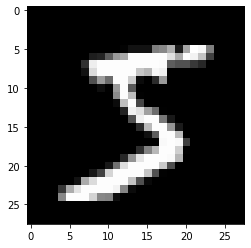

(60000,)
Label:  5


In [7]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

def plot_digit(image):
    """
    This function receives an image and plots the digit. 
    """
    plt.imshow(image, cmap='gray')
    plt.show()

# The x variables contain the images of handwritten digits the y variables contain their labels indicating 
# which digit is in the image. We will see an example of image and label shortly. We have two data sets here:
# training and test sets. The idea is that we use the training set to learn the function and then we evaluate 
# the system on images it did not see during training. This is to simulate the scenario where we build a system
# and we use it in the wild, where people write new digits and we would like our system to accurately recognize them.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Each image is of size 28x28 and the training data set has 60,000 images
# the shape of x_train should then be (60000, 28, 28).
print(x_train.shape)

# Let's take a look at the first training instance. I hope you can recognize the digit 5 in the image.
# Feel free to change the index of x_train to see other images. 
plot_digit(x_train[0])

# The y_train structure has shape 60,0000, with one entry for each image. The value of the first
# entry of y_train should be a five, indicating that the first image is of a 5.
print(y_train.shape)
print('Label: ', y_train[0])

In [8]:
# Instead of using all 60,000 images, we will use "only" 20,000 in our experiments to speed up training.
training_size = 20000

# We will flatten the images to make our implementation easier. Instead of providing 
# an image of size 28x28 as input, we will provide a vector of size 784, with one entry 
# for each pixel of the image. We will also normalize the values in the images. The pixels
# values in the images vary from 0 to 255. We normalize them to avoid overflow. This will 
# be clear later once we better understand the learning algorithm.
images, labels = (x_train[0:training_size].reshape(training_size,28*28) / 255, y_train[0:training_size])

# The flattened images will be kept as column vectors in the matrix images
images = images.T
print('Shape of flattned images: ', images.shape)

# Here we apply the same transformations described above on the test data. 
images_test = x_test.reshape(x_test.shape[0], 28*28) / 255
images_test = images_test.T

Shape of flattned images:  (784, 20000)


<h3>Training a Model</h3>

We will train one function $h_{w_i}$ for each digit $i$, which will be parameterized by a vector $w_i$ and a scalar $b_i$. The vector $w_i$ will contain one entry for each pixel in the flattened image. That way, if an image $x$ contains the digit $i$, then the operation $w_i \cdot x + b$ should produce a number close to $1$; the operation should produce a number close to $0$ if image $x$ does not contain digit $i$. We define $h_{w_i}$ as follows:

\begin{equation*}
h_{w_i} = w_i \cdot x + b
\end{equation*}

Given an image $x$ our model predicts digit $i$ for the largest value returned by $h_{w_i}$ for all $i$. For example, if we pass the first image of the training data x_train[0], then the system will predict the digit 5 correctly if the output of the functions $h_{w_i}$ are similar to the following (these are made-up numbers to illustrate the procedure).

\begin{align*}
h_{w_0} &= 0.1 \\
h_{w_1} &= 0.01 \\
h_{w_2} &= 0.05 \\
h_{w_3} &= 0.25 \\
h_{w_4} &= 0.40 \\
h_{w_5} &= 0.95 \\
h_{w_6} &= 0.80 \\
h_{w_7} &= 0.12 \\
h_{w_8} &= 0.71 \\
h_{w_9} &= 0.01 \\
\end{align*}

Since $h_{w_5}$ is the largest value, the model will predict that the image is of the digit 5.

We will use the training data (variables images and labels) to discover vectors $w_i$ e scalars $b_i$ that classify most of the training data correctly. This will be achieved by defining an error function and then applying gradient descent to minimize the error. We will adjust the values of $w_i$ and $b$ to reduce the error for each function $h$. 

Let $y$ be the label of an image $x$ for a specific function $h_{w_i}$. $y = 0$ if $x$ does not contain the digit $i$ and $y = 1$ otherwise. The error function $J(w_i)$ is defined as the sum of errors for all $m$ images in the training set.
\begin{equation*}
J(w_i) = \frac{1}{2m} \sum_{x, y} (h_{w_i}(x) - y)^2
\end{equation*}
As an example, if $h_{w_i}(x) = 0.95$ for an image that does not contain digit $i$, then the error for this particular image will be $(0.95 - 0)^2 = 0.9025$; if $h_{w_i}(x) = 0$, then the error would have been zero for this instance. The positive error informs gradient descent that the values of $w_i$ need to be adjusted to reduce the error.  

<h3>Gradient Descent</h3>

We will initialize the values of $w_i$ and $b$ with zeros and then adjust them according to gradient descent. 

Let $w_{i, j}$ be the $j$-th value of the vector $w_i$ for digit $i$. The value of $w_{i, j}$ and $b$ will be modified according to gradient descent (see equations below), where $\alpha$ is a small value indicating the size of the step performed by gradient descent. Recall from the lectures that if $\alpha$ is large gradient descent might fail to find the minimum of the error function.   
\begin{align*}
w_{i, j} &= w_{i, j} - \alpha \frac{\partial J(w_i)}{\partial w_{i, j}} \text{ for all }j \hspace{1cm}
\frac{\partial J(w_i)}{\partial w_{i, j}}=(\hat{Y} - Y).X^T \\
b &= b - \alpha \frac{\partial J(w_i)}{\partial b}
\end{align*}

If implemented correctly, the equations above finds values of $w_i$ and $b$ that correctly classify approximately 85\% of the test data. The problem with the approach described is that we need to implement 10 different functions, one for each digit. This is not only time consuming but also computationally expensive. Instead, we will discuss a vectorized version of the algorithm described above. 

<h3> Vectorized Implementation </h3>

In our vectorized implementation the model will produce a vector as output, with one entry for each digit. This way we will not need to implement one function $h_{w_i}$ for each digit, we will implement a single function $h_{W}$ for all digits, where $W$ is a matrix containing all vectors $w_i$ as row vectors. In addition to the matrix $W$, we will use a vector $B$ with one entry for each digit. The input images will be provided as a matrix $X$ with one flattened image in each column of $X$. 

The labels will also be provided as a matrix $Y$ of shape $(10, m)$, where $m$ is the number of instances in the training set. Each column of $Y$ is a one-hot vector (i.e., a vector with one entry equals $1$ and all other entries equal $0$). The entry with value of $1$ in an one-hot vector indicates the digit of the image. 

Here are all matrices we will use in our vectorized representation.

\begin{align*}
X =& 
 \begin{bmatrix}
 p_{0,0} &  p_{0, 1} & \cdots &  p_{0, m-1} \\
 p_{1, 0} &  p_{1,1} & \cdots &  p_{1, m-1} \\
 \cdots & \cdots & \cdots & \cdots \\
  p_{783, 0} &  p_{783, 1} & \cdots &  p_{783, m-1} \\
\end{bmatrix} \\
W =& 
 \begin{bmatrix}
w_{0,0} & w_{0,1} & \cdots & w_{0,783} \\
w_{1,0} & w_{1,1} & \cdots & w_{1,783} \\
\cdots & \cdots & \cdots & \cdots \\
w_{9,0} & w_{9,1} & \cdots & w_{9,783} \\
\end{bmatrix} \\
B =& 
 \begin{bmatrix}
b_0 \\
b_1 \\
\cdots \\
b_9
\end{bmatrix} \\
Y =& 
 \begin{bmatrix}
 y_{0,0} &  y_{0, 1} & \cdots &  y_{0, m-1} \\
 y_{1, 0} &  y_{1,1} & \cdots &  y_{1, m-1} \\
 \cdots & \cdots & \cdots & \cdots \\
  y_{9, 0} &  y_{9, 1} & \cdots & y_{9, m-1} \\
\end{bmatrix} \\
\end{align*}

Using the matrices above we can predict the label of all instances in a data set by performing the following operation: $\hat{Y} = W.$dot$(X) + B$. The largest number in each column of matrix $\hat{Y}$ will indicate the predicted label. 

Complete the code below with gradient descent.

In [9]:
def h_theta(X, W, B):
    """
    For a given matrix W and vector B, this function predicts the value
    of each digit for each image of X. Here we assume that each column of X
    is a flattened image. 
    """
    return W.dot(X) + B 

# Learning rate alpha, for controlling the step of gradient descent
alpha = 0.01

# Number of instances in the training set
m = images.shape[1]

# Matrix W initialized with zeros
W = np.zeros((10, 28*28))

# Matrix B also initialized with zeros
B = np.zeros((10,1))

# Creating Y matrix where each column is an one-hot vector
Y = np.zeros((10, m))
for index, value in enumerate(labels):
    Y[value][index] = 1

# Performs 1000 iterations of gradient descent
ones = np.ones((1,m))
for i in range(1000):
    # Write here your implementation of gradient descent
    W = W - alpha * (W.dot(images) + B - Y).dot(images.T)/m
    B = B - alpha * (W.dot(images) + B - Y).dot(ones.T)/m
 
    
# Once finished performing 1000 gradient descent iterations, then compute the percentage
# of images from the test set classified correctly; print the percentage on the screen.
result = h_theta(images_test, W, B)
print(result.shape)
correct = 0
for i in range(10000):
    highest = 0
    for j in range(10):
        if result[j][i] > result[highest][i]:
            highest = j
    if highest == y_test[i]:
        correct += 1
print("Accuracy:" , correct/10000)

(10, 10000)
Accuracy: 0.8574


By plotting the reshaped image of each vector $w_i$ (reshaped from 784 to 28x28) we can see what the model has learned. You should observe that the image of each vector $w_i$ resembles the digit it is trying to recognize. This is because the dot product $x \cdot w_i$ will be large if $x$ and $w_i$ are similar; the result will be small otherwise. This explains why the image of a vector $w_i$ looks like an average image of many handwritten digits. 

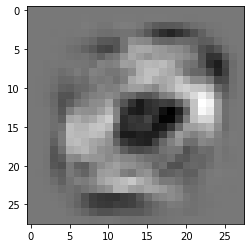

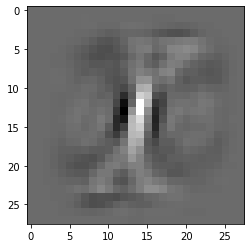

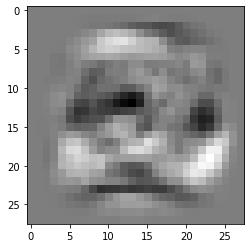

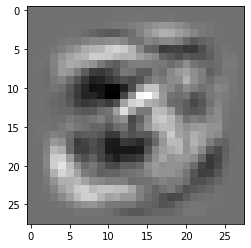

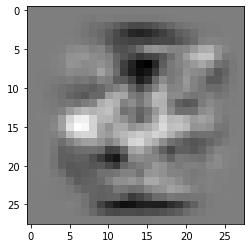

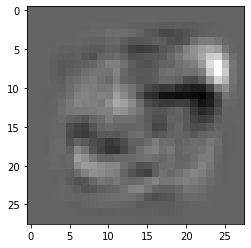

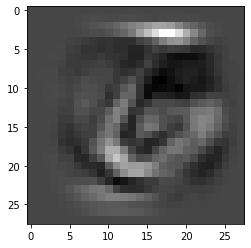

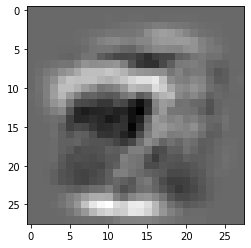

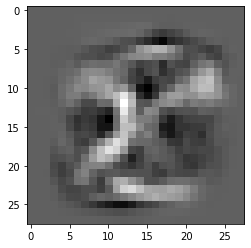

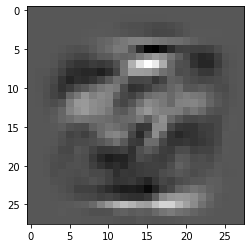

In [10]:
for i in range(10):
    w = W[i,:].reshape(28, 28)
    plot_digit(w)